In [26]:
from math import sqrt
import numpy as np
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from scipy.stats import spearmanr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM, GRU

(26304, 24)
       Atm Pressure   Temperature  ...    NOx_Target     CO_Traget
count  26304.000000  26304.000000  ...  26304.000000  26304.000000
mean     982.872928     25.296901  ...     92.176075   2342.513856
std        6.896038      8.298764  ...     96.524148   2065.708431
min      914.040000      4.060000  ...      2.910000     48.500000
25%      977.060000     18.867000  ...     31.675750   1250.000000
50%      982.797000     26.920000  ...     60.400000   1790.000000
75%      988.850000     31.367000  ...    115.000000   2690.000000
max      999.390000     44.400000  ...   1090.000000  38300.000000

[8 rows x 24 columns]


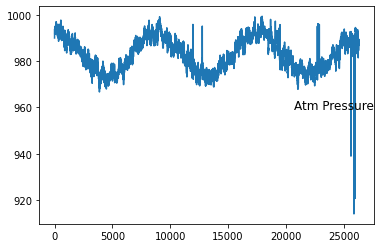

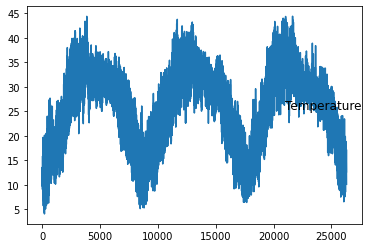

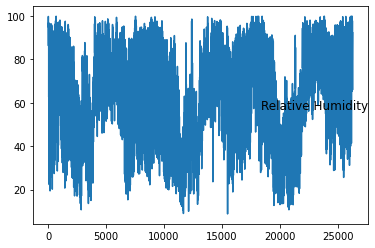

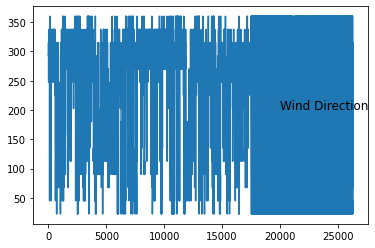

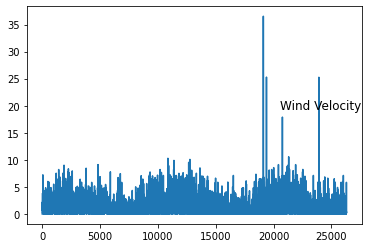

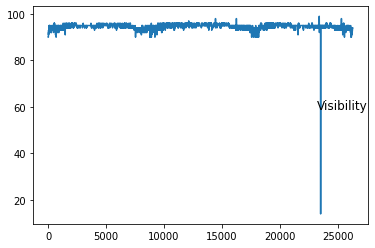

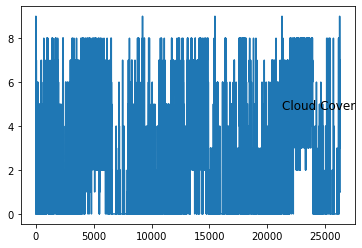

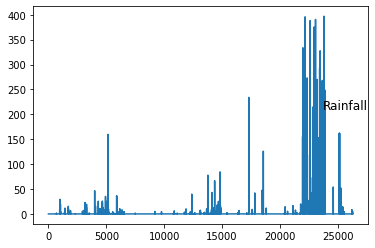

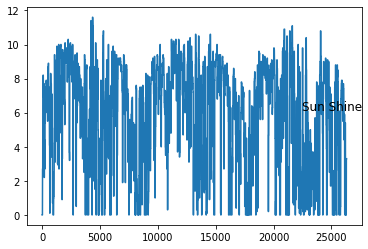

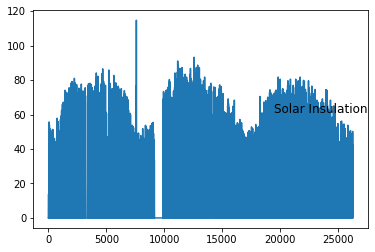

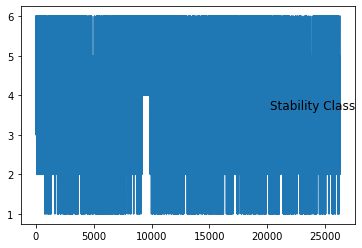

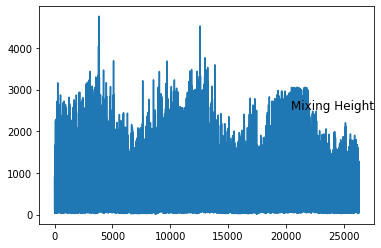

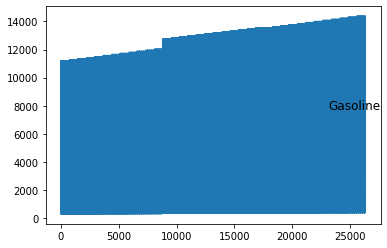

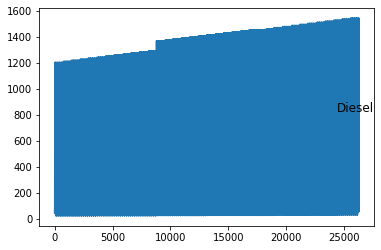

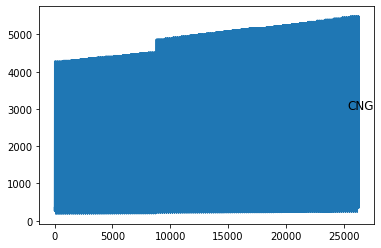

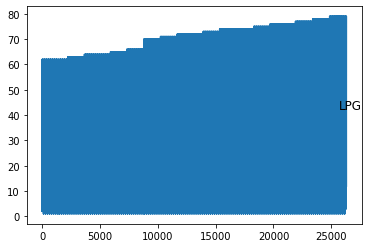

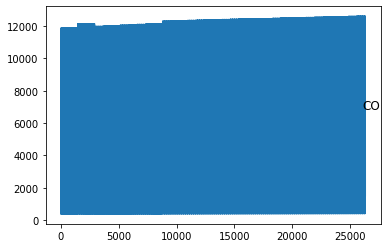

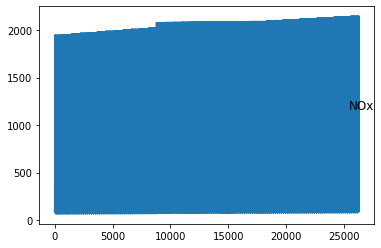

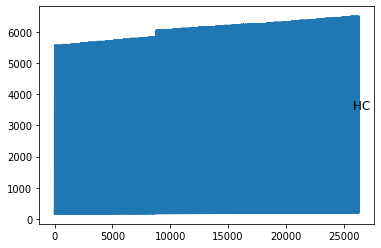

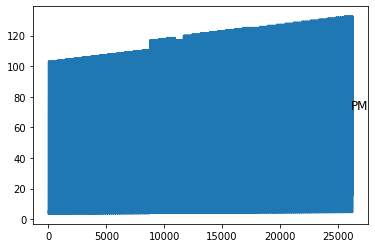

In [27]:
dataframe = read_csv('/content/drive/MyDrive/inno/data.csv', header=0, index_col=0)
print(dataframe.shape)
print(dataframe.describe())
dataset = dataframe.values
def ploter(groups):
  i = 1
  for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(dataset[:, group])
    pyplot.title(dataframe.columns[group], y=0.5, loc='right')
    i += 1
  pyplot.show()
for i in range(0,20):
    group = [i]
    ploter(group)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
dataset = dataframe.values
dataset = dataset.astype('float32')

In [47]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [31]:
data = np.concatenate((dataset[:,0:20], dataset[:,20:21]), axis=1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]], axis=1, inplace=True)

In [32]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 21) (21042,) (5261, 1, 21) (5261,)


Epoch 1/73
281/281 - 3s - loss: 0.0653 - val_loss: 0.0882
Epoch 2/73
281/281 - 1s - loss: 0.0357 - val_loss: 0.0552
Epoch 3/73
281/281 - 1s - loss: 0.0303 - val_loss: 0.0499
Epoch 4/73
281/281 - 1s - loss: 0.0280 - val_loss: 0.0483
Epoch 5/73
281/281 - 1s - loss: 0.0273 - val_loss: 0.0497
Epoch 6/73
281/281 - 1s - loss: 0.0257 - val_loss: 0.0455
Epoch 7/73
281/281 - 1s - loss: 0.0246 - val_loss: 0.0412
Epoch 8/73
281/281 - 1s - loss: 0.0234 - val_loss: 0.0389
Epoch 9/73
281/281 - 1s - loss: 0.0224 - val_loss: 0.0359
Epoch 10/73
281/281 - 1s - loss: 0.0211 - val_loss: 0.0335
Epoch 11/73
281/281 - 1s - loss: 0.0205 - val_loss: 0.0321
Epoch 12/73
281/281 - 1s - loss: 0.0201 - val_loss: 0.0281
Epoch 13/73
281/281 - 1s - loss: 0.0191 - val_loss: 0.0265
Epoch 14/73
281/281 - 1s - loss: 0.0181 - val_loss: 0.0272
Epoch 15/73
281/281 - 1s - loss: 0.0174 - val_loss: 0.0282
Epoch 16/73
281/281 - 1s - loss: 0.0170 - val_loss: 0.0282
Epoch 17/73
281/281 - 1s - loss: 0.0167 - val_loss: 0.0254
Epoch 

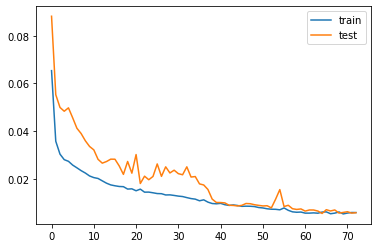

In [33]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=73, batch_size=75, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.382
Test CC(Corelation Coefficient)     : 0.990
980.8329059750923
5261
5261
Test PB(Percentage Bias)            : 0.000
Test NSE(Nash Sutcliffe Efficiency) : 0.954


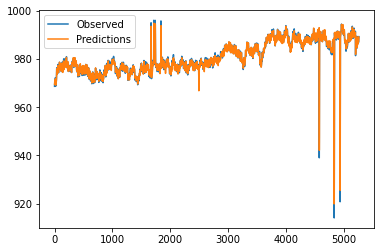

In [34]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat)
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0.000, 0.000, 0.000, 0.000
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)

for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0.000, 0.000
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [35]:
data = np.concatenate((dataset[:,0:20], dataset[:,21:22]), axis=1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]], axis=1, inplace=True)

In [36]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 21) (21042,) (5261, 1, 21) (5261,)


Epoch 1/72
264/264 - 3s - loss: 0.0721 - val_loss: 0.0758
Epoch 2/72
264/264 - 1s - loss: 0.0362 - val_loss: 0.0550
Epoch 3/72
264/264 - 1s - loss: 0.0301 - val_loss: 0.0457
Epoch 4/72
264/264 - 1s - loss: 0.0274 - val_loss: 0.0419
Epoch 5/72
264/264 - 1s - loss: 0.0260 - val_loss: 0.0411
Epoch 6/72
264/264 - 1s - loss: 0.0249 - val_loss: 0.0432
Epoch 7/72
264/264 - 1s - loss: 0.0241 - val_loss: 0.0385
Epoch 8/72
264/264 - 1s - loss: 0.0233 - val_loss: 0.0349
Epoch 9/72
264/264 - 1s - loss: 0.0225 - val_loss: 0.0343
Epoch 10/72
264/264 - 1s - loss: 0.0216 - val_loss: 0.0306
Epoch 11/72
264/264 - 1s - loss: 0.0207 - val_loss: 0.0304
Epoch 12/72
264/264 - 1s - loss: 0.0203 - val_loss: 0.0289
Epoch 13/72
264/264 - 1s - loss: 0.0198 - val_loss: 0.0282
Epoch 14/72
264/264 - 1s - loss: 0.0193 - val_loss: 0.0266
Epoch 15/72
264/264 - 1s - loss: 0.0191 - val_loss: 0.0246
Epoch 16/72
264/264 - 1s - loss: 0.0188 - val_loss: 0.0232
Epoch 17/72
264/264 - 1s - loss: 0.0184 - val_loss: 0.0219
Epoch 

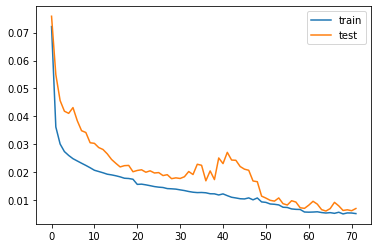

In [37]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.453
Test CC(Corelation Coefficient)     : 0.988
Test PB(Percentage Bias)            : 0.000
Test NSE(Nash Sutcliffe Efficiency) : 0.949


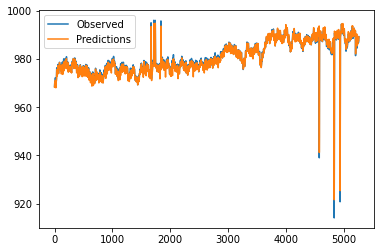

In [38]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# plt.plot()


rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [39]:
data = np.concatenate((dataset[:,0:20], dataset[:,22:23]), axis=1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]], axis=1, inplace=True)

In [40]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 21) (21042,) (5261, 1, 21) (5261,)


Epoch 1/72
121/121 - 3s - loss: 0.1261 - val_loss: 0.0602
Epoch 2/72
121/121 - 0s - loss: 0.0360 - val_loss: 0.0531
Epoch 3/72
121/121 - 0s - loss: 0.0315 - val_loss: 0.0523
Epoch 4/72
121/121 - 0s - loss: 0.0315 - val_loss: 0.0528
Epoch 5/72
121/121 - 0s - loss: 0.0325 - val_loss: 0.0519
Epoch 6/72
121/121 - 0s - loss: 0.0336 - val_loss: 0.0539
Epoch 7/72
121/121 - 0s - loss: 0.0452 - val_loss: 0.0537
Epoch 8/72
121/121 - 0s - loss: 0.0520 - val_loss: 0.0536
Epoch 9/72
121/121 - 0s - loss: 0.0510 - val_loss: 0.0540
Epoch 10/72
121/121 - 0s - loss: 0.0535 - val_loss: 0.0524
Epoch 11/72
121/121 - 0s - loss: 0.0623 - val_loss: 0.0492
Epoch 12/72
121/121 - 0s - loss: 0.0596 - val_loss: 0.0470
Epoch 13/72
121/121 - 0s - loss: 0.0590 - val_loss: 0.0446
Epoch 14/72
121/121 - 0s - loss: 0.0564 - val_loss: 0.0429
Epoch 15/72
121/121 - 0s - loss: 0.0524 - val_loss: 0.0415
Epoch 16/72
121/121 - 0s - loss: 0.0500 - val_loss: 0.0407
Epoch 17/72
121/121 - 0s - loss: 0.0479 - val_loss: 0.0398
Epoch 

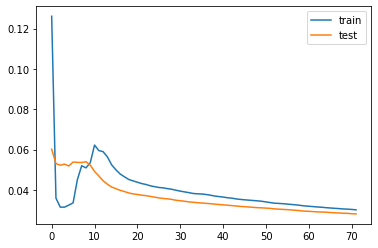

In [41]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=175, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 3.604
Test CC(Corelation Coefficient)     : 0.896
Test PB(Percentage Bias)            : -0.001
Test NSE(Nash Sutcliffe Efficiency) : 0.684


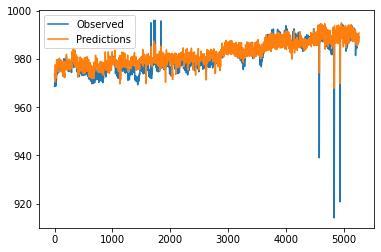

In [42]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [43]:
# dataset = dataframe.values
# dataset = dataset.astype('float32')
z =  dataset[:,23]
z = z.reshape(z.shape[0],1)
data = np.concatenate((dataset[:,0:20],z), axis=1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]], axis=1, inplace=True)

In [44]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 21) (21042,) (5261, 1, 21) (5261,)


Epoch 1/69
222/222 - 3s - loss: 0.0944 - val_loss: 0.0905
Epoch 2/69
222/222 - 0s - loss: 0.0438 - val_loss: 0.0763
Epoch 3/69
222/222 - 1s - loss: 0.0404 - val_loss: 0.0628
Epoch 4/69
222/222 - 1s - loss: 0.0364 - val_loss: 0.0557
Epoch 5/69
222/222 - 1s - loss: 0.0336 - val_loss: 0.0496
Epoch 6/69
222/222 - 1s - loss: 0.0314 - val_loss: 0.0463
Epoch 7/69
222/222 - 0s - loss: 0.0297 - val_loss: 0.0439
Epoch 8/69
222/222 - 1s - loss: 0.0279 - val_loss: 0.0423
Epoch 9/69
222/222 - 1s - loss: 0.0268 - val_loss: 0.0411
Epoch 10/69
222/222 - 1s - loss: 0.0259 - val_loss: 0.0397
Epoch 11/69
222/222 - 1s - loss: 0.0252 - val_loss: 0.0384
Epoch 12/69
222/222 - 1s - loss: 0.0245 - val_loss: 0.0376
Epoch 13/69
222/222 - 1s - loss: 0.0240 - val_loss: 0.0372
Epoch 14/69
222/222 - 1s - loss: 0.0235 - val_loss: 0.0363
Epoch 15/69
222/222 - 1s - loss: 0.0231 - val_loss: 0.0354
Epoch 16/69
222/222 - 1s - loss: 0.0228 - val_loss: 0.0344
Epoch 17/69
222/222 - 1s - loss: 0.0224 - val_loss: 0.0337
Epoch 

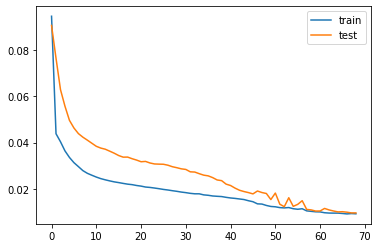

In [45]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=69, batch_size=95, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.616
Test CC(Corelation Coefficient)     : 0.981
Test PB(Percentage Bias)            : 0.000
Test NSE(Nash Sutcliffe Efficiency) : 0.937


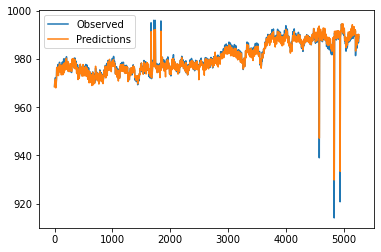

In [46]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = 1 - (num/den)
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()